**Requirements:** 

* Python Version: 3.11.11
* PyTorch Version: '2.6.0+cu124'

In [1]:
# Dataset creation
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles (n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                       "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


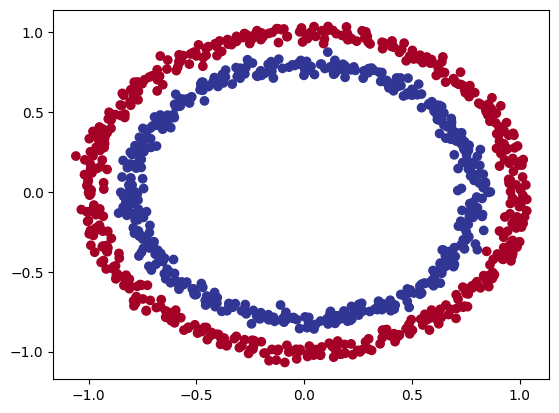

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
           y=X[:,1],
           c=y,
           cmap=plt.cm.RdYlBu);

In [5]:
# 1.1 Check input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X_sample = X[0]
y_sample = y[0]
X_sample, X_sample.shape
y_sample, y_sample.shape
print(f"Values of X_sample[0]: {X_sample} y_sample[0]: {y_sample}")
print(f"Shape of X_sample: {X_sample.shape} and y_sample: {y_sample.shape}")

Values of X_sample[0]: [0.75424625 0.23148074] y_sample[0]: 1
Shape of X_sample: (2,) and y_sample: ()


In [7]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [8]:
### 1.2 Turn data into Tensor and create train and test

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)


In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Model

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) 

# Instantiate an instance of our model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
next(model_0.parameters()).device

device(type='cpu')

In [14]:
# Using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [17]:
# Raw Logits [without activation function]
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
    
y_logits

tensor([[ 0.0022],
        [-0.1251],
        [ 0.2855],
        [-0.0778],
        [ 0.2052]])

In [18]:
# Sigmoid activation 
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5006],
        [0.4688],
        [0.5709],
        [0.4806],
        [0.5511]])

In [19]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 0., 1.])

In [20]:
y_preds = torch.round(y)

# Buliding Trianing and Test Loop

In [21]:
# Buliding Trianing and Test Loop

epochs = 100


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) 

    # Calculate loss and accuracy
    # loss = loss_fn(torch.sigmoid(y_logits)) # nn.BCELoss expect prediction probabilities
    loss = loss_fn(y_logits, #nn.BCEWithLogitsLoss
                  y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

    # Optimizer
    optimizer.zero_grad() 

    #Loss Backward (backpropagation)
    loss.backward()

    # Optimizer Step (gradient descent)
    optimizer.step()
    
    # Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)
    # Print
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Acc: {test_loss:.5f}%")
        

Epoch: 0 | Loss: 0.70007, Acc: 51.00% | Test loss: 0.69163 | Test Acc: 0.69163%
Epoch: 10 | Loss: 0.69808, Acc: 50.38% | Test loss: 0.69088 | Test Acc: 0.69088%
Epoch: 20 | Loss: 0.69686, Acc: 50.00% | Test loss: 0.69068 | Test Acc: 0.69068%
Epoch: 30 | Loss: 0.69601, Acc: 49.75% | Test loss: 0.69069 | Test Acc: 0.69069%
Epoch: 40 | Loss: 0.69537, Acc: 49.25% | Test loss: 0.69081 | Test Acc: 0.69081%
Epoch: 50 | Loss: 0.69487, Acc: 49.50% | Test loss: 0.69099 | Test Acc: 0.69099%
Epoch: 60 | Loss: 0.69449, Acc: 49.00% | Test loss: 0.69119 | Test Acc: 0.69119%
Epoch: 70 | Loss: 0.69419, Acc: 49.12% | Test loss: 0.69142 | Test Acc: 0.69142%
Epoch: 80 | Loss: 0.69395, Acc: 49.12% | Test loss: 0.69165 | Test Acc: 0.69165%
Epoch: 90 | Loss: 0.69376, Acc: 49.00% | Test loss: 0.69187 | Test Acc: 0.69187%


In [22]:
# Download Python file and use

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("exist!")
else:
    print("downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py") 
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

downloading


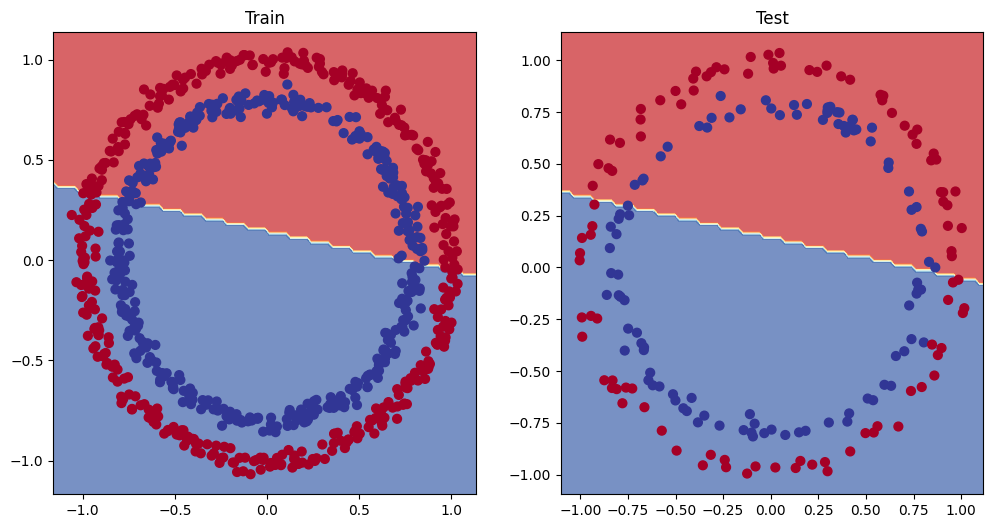

In [23]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features = 1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.1)

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()
    ### Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    ### Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    ### Optimizer zero grad
    optimizer.zero_grad()
    ### Loss backward
    loss.backward()
    ### Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # Forward
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Loss
        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.5f}%")

Epoch: 0 | Loss: 0.70096, Acc: 50.37500% | Test Loss: 0.69780, Test Acc: 51.00000%
Epoch: 100 | Loss: 0.69352, Acc: 49.75000% | Test Loss: 0.69486, Test Acc: 49.00000%
Epoch: 200 | Loss: 0.69305, Acc: 50.75000% | Test Loss: 0.69486, Test Acc: 47.00000%
Epoch: 300 | Loss: 0.69299, Acc: 51.00000% | Test Loss: 0.69480, Test Acc: 45.50000%
Epoch: 400 | Loss: 0.69298, Acc: 51.37500% | Test Loss: 0.69475, Test Acc: 46.00000%
Epoch: 500 | Loss: 0.69298, Acc: 51.25000% | Test Loss: 0.69471, Test Acc: 45.50000%
Epoch: 600 | Loss: 0.69298, Acc: 51.25000% | Test Loss: 0.69469, Test Acc: 45.50000%
Epoch: 700 | Loss: 0.69298, Acc: 51.12500% | Test Loss: 0.69469, Test Acc: 46.00000%
Epoch: 800 | Loss: 0.69298, Acc: 51.12500% | Test Loss: 0.69468, Test Acc: 46.00000%
Epoch: 900 | Loss: 0.69298, Acc: 51.12500% | Test Loss: 0.69468, Test Acc: 46.00000%


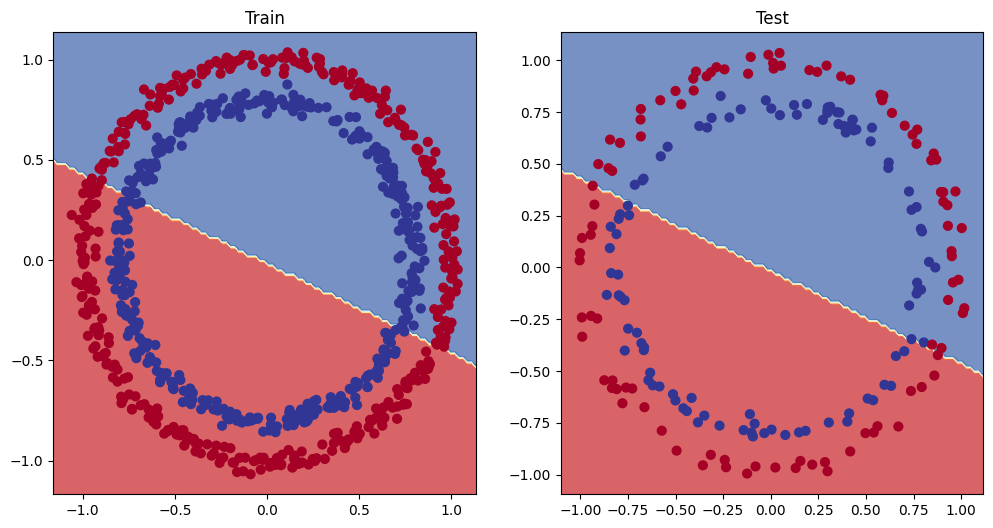

In [27]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

In [28]:
### Troubleshoot
weight = 0.7
bias = 0.3
start = 0
end = 1 
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

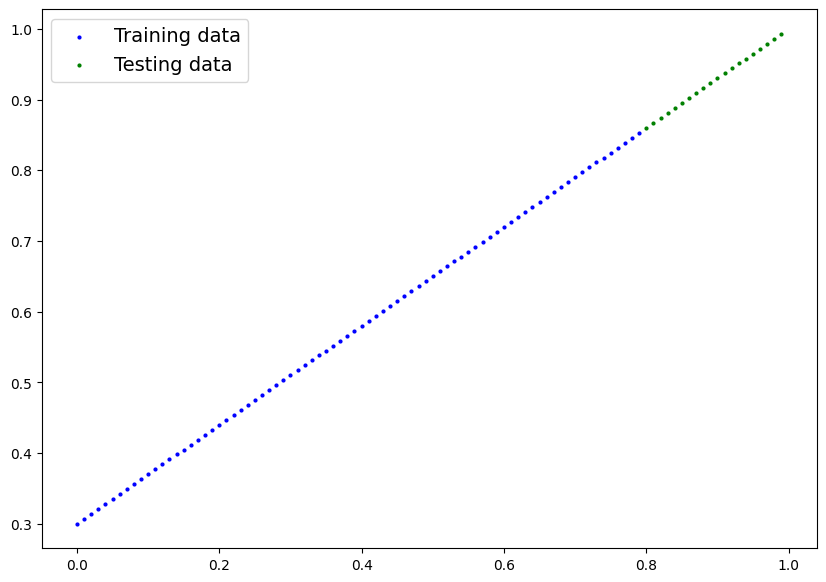

In [30]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)

In [31]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr=0.01)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
    

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


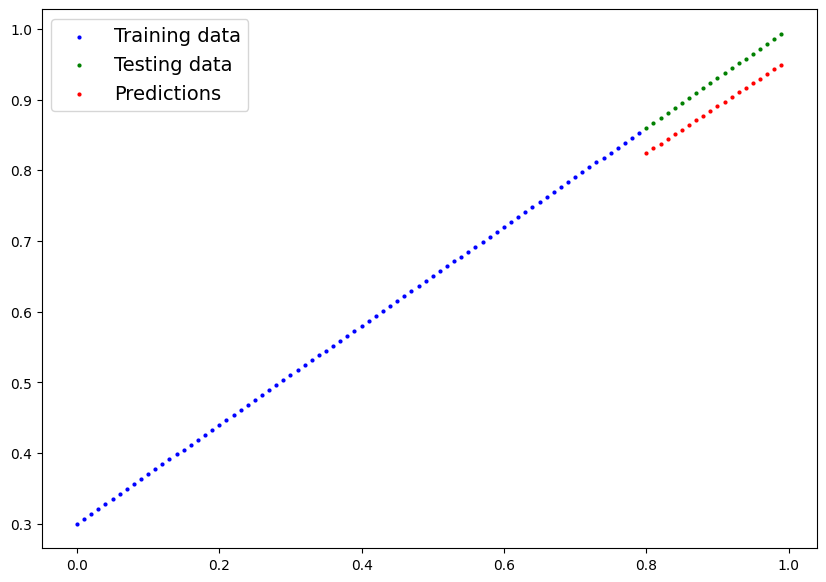

In [34]:
# Evaluation
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression,
                predictions=y_preds)

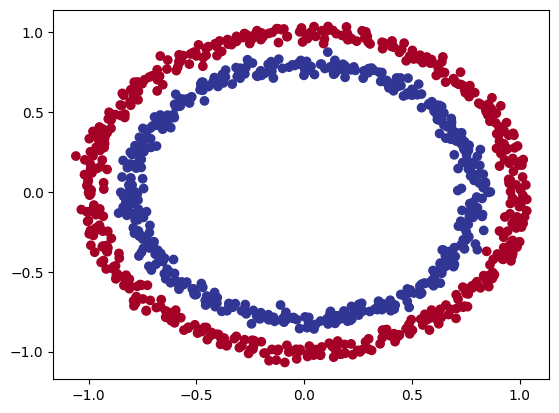

In [35]:
# Recreating non linear data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                  noise=0.03,
                  random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [36]:
# Non Linearity
import torch
from sklearn.model_selection import train_test_split

# Turn data to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [37]:
# Bulilding model with non linearity
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [38]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                           lr=0.1)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_3.train()
    
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)

    if epoch % 100 == 0:
         print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.5f}%")
    

Epoch: 0 | Loss: 0.69295, Acc: 50.00000% | Test Loss: 0.69319, Test Acc: 50.00000%
Epoch: 100 | Loss: 0.69115, Acc: 52.87500% | Test Loss: 0.69102, Test Acc: 52.50000%
Epoch: 200 | Loss: 0.68977, Acc: 53.37500% | Test Loss: 0.68940, Test Acc: 55.00000%
Epoch: 300 | Loss: 0.68795, Acc: 53.00000% | Test Loss: 0.68723, Test Acc: 56.00000%
Epoch: 400 | Loss: 0.68517, Acc: 52.75000% | Test Loss: 0.68411, Test Acc: 56.50000%
Epoch: 500 | Loss: 0.68102, Acc: 52.75000% | Test Loss: 0.67941, Test Acc: 56.50000%
Epoch: 600 | Loss: 0.67515, Acc: 54.50000% | Test Loss: 0.67285, Test Acc: 56.00000%
Epoch: 700 | Loss: 0.66659, Acc: 58.37500% | Test Loss: 0.66322, Test Acc: 59.00000%
Epoch: 800 | Loss: 0.65160, Acc: 64.00000% | Test Loss: 0.64757, Test Acc: 67.50000%
Epoch: 900 | Loss: 0.62362, Acc: 74.00000% | Test Loss: 0.62145, Test Acc: 79.00000%


In [43]:
# Evaluating
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

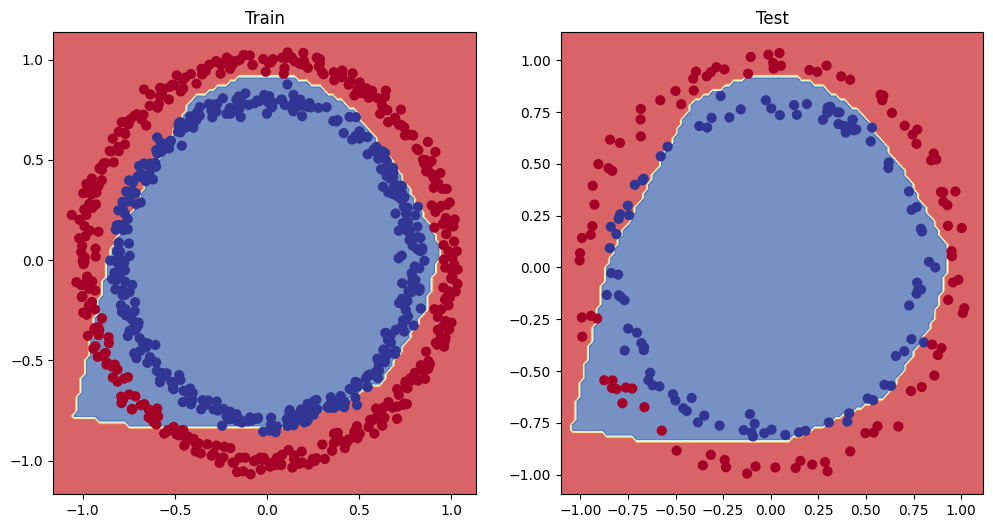

In [46]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)